In [2]:
import pandas as pd 
import numpy as np
import yfinance as yf
import wrds
import copy
import datetime as dt
import matplotlib.pyplot as plt

In [3]:
tickers = ['AAPL', 'AMZN', 'C', 'CVS', 'MMM', 'SBUX', 'SCHW', 'XOM']
start = '2000-06-02'
end = '2016-04-26' 
end2 = dt.datetime.today()

### Import Data

In [103]:
#FROM R
Rdata = pd.read_csv('/Users/riccardo/OneDrive/OneDrive - UOM/ZDGN/Data_Intelligent_Port_Construction.csv')
Rdata = Rdata.rename(columns={'Unnamed: 0':'Date'})
Rdata.set_index('Date', inplace=True)

In [7]:
AdjClose = yf.download(tickers, start=start, end=end)['Adj Close']
Volume = yf.download(tickers, start=start, end=end)['Volume']
High = yf.download(tickers, start=start, end=end)['High']
Low = yf.download(tickers, start=start, end=end)['Low']
Close = yf.download(tickers, start=start, end=end)['Close']

[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  8 of 8 completed


In [8]:
AdjClose_Validation = yf.download(tickers, start=end, end=end2)['Adj Close']
Volume_Validation = yf.download(tickers, start=end, end=end2)['Volume']
High_Validation = yf.download(tickers, start=end, end=end2)['High']
Low_Validation = yf.download(tickers, start=end, end=end2)['Low']
Close_Validation = yf.download(tickers, start=end, end=end2)['Close']

[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  8 of 8 completed


### Exponential Smoothing Function

In [1095]:
def exponential_smoothing(df, alpha):
    DF = df.copy().reset_index(drop=True)
    #DF['Predicted'] = 0
    #DF.Predicted.loc[0] = DF.loc[0][0]
    
    #DF.Predicted.loc[1] = (DF.loc[1][0]*alpha)+(DF.Predicted.loc[0]*(1-alpha))
    
    #for i in range(2, len(DF)):
        #DF.Predicted[i] = (DF.loc[i][0]*alpha)+(DF.Predicted.loc[i-1]*(1-alpha))
    #DF.Predicted = (DF.iloc[:,0][1:]*alpha) + (DF.Predicted.shift(1)*(1-alpha))
    
    return DF

In [10]:
def exponential_smoothing(df, alpha):
    DF = df.copy().reset_index(drop=True) 
    DF.loc[1] = (DF.loc[1]*alpha)+(DF.loc[0]*(1-alpha))
    
    for i in range(2, len(DF)-1):
        DF[i] = (DF[i]*alpha)+(DF[i-1]*(1-alpha))
    
    return DF

E = {}
for n in AdjClose.columns:
    E[f'{n}']= exponential_smoothing(AdjClose[n], 0.2)

In [112]:
d = {}
for n in AdjClose.columns:
    d[f'{n}']= exponential_smoothing(pd.DataFrame(AdjClose[n]).reset_index(drop=True), 0.2)

/Users/riccardo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


### Feature Derivation

#### On Balance Volume

In [11]:
def OBV(df_price, df_volume):
    OBV_df = pd.DataFrame(index=range(len(df_volume.index)), columns=['OBV'])
    OBV_df.iloc[0] = 0
    
    for i in range(1, len(df_price)):
        if df_price[i] > df_price[i-1]:
            OBV_df.loc[i] = (OBV_df.loc[i-1] + df_volume[i])
        elif df_price[i] < df_price[i-1]:
            OBV_df.loc[i] = (OBV_df.loc[i-1] - df_volume[i])
        else:
            OBV_df.loc[i] = (OBV_df.loc[i-1] + 0)
    
    OBV_df.index = df_volume.index
    return OBV_df

O = {}
for n in AdjClose.columns:
    O[f'{n}']= OBV(E[n], Volume[n])

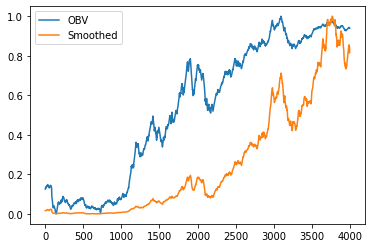

In [36]:
plt.plot(((O['AAPL']-O['AAPL'].min())/(O['AAPL'].max()-O['AAPL'].min())).reset_index(drop=True), label='OBV')
plt.plot((E['AAPL']-E['AAPL'].min())/(E['AAPL'].max()-E['AAPL'].min()), label='Smoothed')
plt.legend()
plt.savefig('/Users/riccardo/OneDrive/OneDrive - UOM/ZDGN/Intelligent Portfolio/OBV')

#### Stochastic Oscillator

In [57]:
def stochastic_oscillator(close, df_low, df_high, K):
    "remember not to use AdjClose"
    low = df_low.rolling(K).min().reset_index(drop=True)
    high = df_high.rolling(K).max().reset_index(drop=True)
    
    stoch_oscillator = pd.DataFrame()
    stoch_oscillator['Oscillator'] = 100*((close - low)/(high - low))
    
    return stoch_oscillator

S = {}
for n in AdjClose.columns:
    S[f'{n}']= stochastic_oscillator(close=E[n], df_low=E[n], df_high=E[n], K=14)

#### Moving Average Convergence Divergence

In [38]:
def MACD_dict(df):
    DF = df.copy()
    #DF.reset_index(drop=True)
    DF['MA_Fast'] = DF.Predicted.ewm(span=12,min_periods=12).mean()
    DF['MA_Slow'] = DF.Predicted.ewm(span=26,min_periods=26).mean()
    DF['MACD'] = DF['MA_Fast'] - DF['MA_Slow']
    DF['Signal'] = DF['MACD'].ewm(span=9,min_periods=9).mean()
    #df.dropna(inplace=True)
    df.index = DF.index
    return (DF[['MACD', 'Signal']])

In [198]:
# New One for Validation Set
def MACD(data):
    #DF = pd.DataFrame(index=E['AAPL'].index, columns=[['MA_Fast', 'MA_Slow', 'MACD', 'Signal']])
    MA_Fast = data.ewm(span=12,min_periods=12).mean()
    MA_Slow = data.ewm(span=26,min_periods=26).mean()
    MACD = MA_Fast - MA_Slow
    Signal = MACD.ewm(span=9,min_periods=9).mean()
    #df.dropna(inplace=True)
    #df.index = DF.index
    return pd.DataFrame(index=['MACD', 'Signal'], data=[MACD,Signal]).T

M = {}
for n in AdjClose.columns:
    M[f'{n}'] = MACD(data=E[n])

In [47]:
for n in AdjClose.columns:
    M[f'{n}'] = MACD(data=E[n])

M = {}
for n in range(0,8):
    M[f'{AdjClose.columns[n]}'] = MACD_dict(df=d[AdjClose.columns[n]])

NameError: name 'd' is not defined

### Application of all functions to validation set

In [90]:
# Smoothing
E_validation = {}
for n in AdjClose_Validation.columns:
    E_validation[f'{n}']= exponential_smoothing(AdjClose_Validation[n], 0.2)
    
# On Balance Volume
O_validation = {}
for n in AdjClose_Validation.columns:
    O_validation[f'{n}']= OBV(E_validation[n], Volume_Validation[n])

# Stochastic Oscillator
S_validation = {}
for n in AdjClose_Validation.columns:
    S_validation[f'{n}']= stochastic_oscillator(close=E_validation[n], df_low=E_validation[n], df_high=E_validation[n], K=14)
    
# Moving Average Convergence Divergence
M_validation = {}
for n in AdjClose_Validation.columns:
    M_validation[f'{n}'] = MACD(data=pd.Series(E_validation[n]))
    
# Concatenate all together    
dict_data_validation = {}
for n in AdjClose_Validation.columns:
    dict_data_validation[f'{n}'] = (pd.concat([E_validation[n], 
                                               O_validation[n].reset_index(drop=True), 
                                               S_validation[n], 
                                               M_validation[n]], axis=1)).set_index(O_validation[n].index)

### Concatenate functions in a single dictionary

In [72]:
dict_data = {}
for n in AdjClose.columns:
    dict_data[f'{n}'] = (pd.concat([E[n], 
                                    O[n].reset_index(drop=True), 
                                    S[n], 
                                    M[n]],
                                   axis=1)).set_index(O[n].index)

### Function to classify the dependent variable Smoothed AdjClose Price as -1 or 1

In [75]:
def finalise_data(DF, column, n):
    df = copy.deepcopy(DF)
    df[column][column] = np.sign(np.log(df[column][column]/df[column][column].shift(n-1)))
    
    return df[column]

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [77]:
def RFClassifier(DF, column, n, validation=False, validation_DF=None):
    data = finalise_data(DF=DF, column=column, n=n)
    data.dropna(axis=0, inplace=True)
    
    X = data[['OBV', 'Oscillator', 'MACD', 'Signal']]
    y = data[column]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    model = RandomForestClassifier(n_estimators=100)
    model.fit(X_train,y_train)
    prediction= model.predict(X_test)
    
    Accuracy = metrics.accuracy_score(y_test, prediction)
    Precision = metrics.average_precision_score(y_test, prediction)
    Recall = metrics.recall_score(y_test, prediction)
    F1_score = metrics.f1_score(y_test, prediction)
    
    if validation ==  True:
        validation_data = finalise_data(DF=validation_DF, column=column, n=n)
        validation_data.dropna(axis=0, inplace=True)
        
        X_validation = validation_data[['OBV', 'Oscillator', 'MACD', 'Signal']]
        y_validation = validation_data[column]
        validation_prediction = model.predict(X_validation)
        
        Accuracy_validation = metrics.accuracy_score(y_validation, validation_prediction)
        Precision_validation = metrics.average_precision_score(y_validation, validation_prediction)
        Recall_validation = metrics.recall_score(y_validation, validation_prediction)
        F1_score_validation = metrics.f1_score(y_validation, validation_prediction)
        
        return n, column,Accuracy_validation, Precision_validation, Recall_validation, F1_score_validation
    
    return n, column, Accuracy, Precision, Recall, F1_score

In [154]:
def RFClassifier(DF, column, n, validation=False, validation_DF=None, feature_importance=False):
    data = finalise_data(DF=DF, column=column, n=n)
    data.dropna(axis=0, inplace=True)
    
    X = data[['OBV', 'Oscillator', 'MACD', 'Signal']]
    y = data[column]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    model = RandomForestClassifier(n_estimators=100)
    model.fit(X_train,y_train)
    prediction= model.predict(X_test)
    
    Accuracy = metrics.accuracy_score(y_test, prediction)
    Precision = metrics.average_precision_score(y_test, prediction)
    Recall = metrics.recall_score(y_test, prediction)
    F1_score = metrics.f1_score(y_test, prediction)
    
    if validation ==  True:
        validation_data = finalise_data(DF=validation_DF, column=column, n=n)
        validation_data.dropna(axis=0, inplace=True)
        
        X_validation = validation_data[['OBV', 'Oscillator', 'MACD', 'Signal']]
        y_validation = validation_data[column]
        validation_prediction = model.predict(X_validation)
        
        Accuracy_validation = metrics.accuracy_score(y_validation, validation_prediction)
        Precision_validation = metrics.average_precision_score(y_validation, validation_prediction)
        Recall_validation = metrics.recall_score(y_validation, validation_prediction)
        F1_score_validation = metrics.f1_score(y_validation, validation_prediction)
        
        return n, column,Accuracy_validation, Precision_validation, Recall_validation, F1_score_validation
    
    elif feature_importance == True:
        return pd.Series(model.feature_importances_,(X).columns)
        
    else:
        return n, column, Accuracy, Precision, Recall, F1_score

In [79]:
train_test = []
for i in AdjClose.columns:
    for m in range(2,31):
        train_test.append(RFClassifier(DF=dict_data, column=i, n=m))
result = pd.DataFrame(np.array(train_test), columns=['n', 'Ticker', 'Accuracy', 'Precision', 'Recall', 'F1_score'])
result[['F1_score','Recall','Precision','Accuracy']]=result[['F1_score','Recall','Precision','Accuracy']].astype(float)
result['n']=result['n'].astype(int)

In [91]:
validation_res = []
for i in AdjClose.columns:
    for m in range(2,31):
        validation_res.append(RFClassifier(DF=dict_data, column=i, n=m, validation=True, validation_DF=dict_data_validation))
validation_result = pd.DataFrame(np.array(validation_res), columns=['n', 'Ticker', 'AccuracyV', 'PrecisionV', 'RecallV', 'F1_scoreV'])
validation_result[['F1_scoreV','RecallV','PrecisionV','AccuracyV']]=validation_result[['F1_scoreV','RecallV','PrecisionV','AccuracyV']].astype(float)
validation_result['n']=validation_result['n'].astype(int)

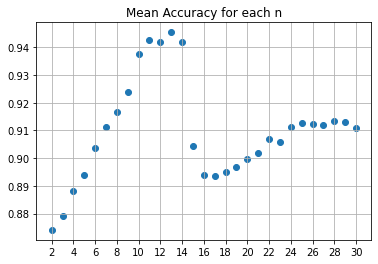

In [140]:
plt.title('Mean Accuracy for each n')
plt.scatter(validation_result.groupby('n').mean().index, validation_result.groupby('n').mean().AccuracyV)
plt.xticks(np.arange(min(validation_result.groupby('n').mean().index), max(validation_result.groupby('n').mean().index)+1, 2.0))
plt.grid()
plt.savefig('/Users/riccardo/OneDrive/OneDrive - UOM/ZDGN/Intelligent Portfolio/Mean Accuracy RF Classifer')

In [167]:
feature_importances = []
for i in AdjClose.columns:
    for m in range(2,31):
        feature_importances.append(RFClassifier(DF=dict_data, column=i, n=m, validation=False, validation_DF=None, feature_importance=True))
feature_importances_df = pd.DataFrame(np.array(feature_importances), columns=[['OBV', 'Oscillator', 'MACD', 'Signal']], index=result.n)

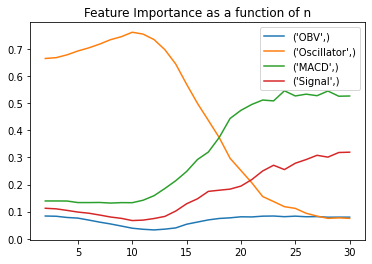

In [197]:
plt.title('Feature Importance as a function of n')
plt.plot(feature_importances_df.groupby(feature_importances_df.index).mean(), label=feature_importances_df.columns)
plt.legend()
plt.savefig('/Users/riccardo/OneDrive/OneDrive - UOM/ZDGN/Intelligent Portfolio/Feature Importance as a function of n')

In [228]:
plt.figure(figsize=(20,20))
_ = tree.plot_tree(random_for_prova.estimators_[0], feature_names=X_prova.columns, filled=True)

NameError: name 'tree' is not defined

<Figure size 1440x1440 with 0 Axes>

In [230]:
feature_importances_df.groupby(feature_importances_df.index).mean()

,OBV,Oscillator,MACD,Signal
n,,,,
2,0.083897,0.664310,0.139361,0.112432
3,0.083016,0.667354,0.139327,0.110304
4,0.078546,0.677720,0.139120,0.104615
5,0.076139,0.691996,0.133455,0.098409
6,0.068955,0.703414,0.133391,0.094241
7,0.061367,0.717300,0.133811,0.087522
8,0.054646,0.733561,0.131588,0.080205
9,0.046913,0.744636,0.133221,0.075230
10,0.038930,0.761000,0.132934,0.067136
